# Generating Annihilation Rates from Remote Cache of Particle Model
Tim Tyree

In [1]:
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [5]:
# #FK (a_hat short timescale, D_hat long timescale)
a_hat_FK=7.3923;D_hat_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'

#LR (a_hat short timescale, D_hat long timescale)
a_hat_LR=8.595;D_hat_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'

# load the resulting table of powerlaw fits and perform interpolation to estimate M,nu

In [7]:
#neighbor-only forces
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
#vector-summed forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
# df.tail()

In [30]:
#define constant parameters
neighbor=1
# neighbor=0
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','varkappa','D']#,x0
output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#?? minute runtime
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
yhat = interp(X)
print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

rmse=np.sqrt(np.mean((yhat-y)**2))
print(f"the rmse of simple interpolation is {rmse:.4f}")

number of training examples is 17916.
training complete!
shape of X (17916, 4) --> shape of y=yhat (17916, 2)
the rmse of simple interpolation is 0.0000


In [ ]:
from scipy.optimize import minimize

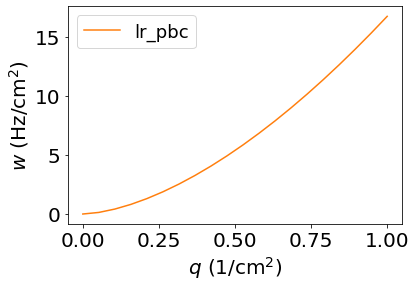

In [24]:
#TODO: dev function from parameter setting to rmse_full
#GOAL: find a best r,kappa pair for a given a,D pair for a given full model
model_name='lr_pbc'
c='C1'
#estimate q_values,w_values 
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
plt.plot(q_values,w_values,c=c,label=model_name)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=18)
plt.show()

In [29]:
r=0.1
kappa=100
a=a_hat_LR
D=D_hat_LR

#interpolate nu and M using interp
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,2]

In [ ]:
yhat = interp(X)
#TODO: compute what_values
#TODO: compute rmse to w_values
#TODO: return the best r


In [25]:
args=(a,D,q_values,w_values)
x=(r,kappa)
def fun(x, *args):
    a,D,q_values,w_values=args
    r,kappa=x
    rmse_full=np.nan
    return rmse_full

#TODO: test for a significant speedup by baking in interp
# args=(a,D,q_values,w_values,interp)
# x=(r,kappa)
# def fun(x, *args):
#     a,D,q_values,w_values,interp=args
#     r,kappa=x
#     rmse_full=np.nan
#     return rmse_full

#TODO(option A): use minimize
#TODO(option B): loop over an array of r_values, loop over an array of kappa_values
#TODO(if ^that is prohibitively slow): look for a scipy routine that finds the optimal r,kappa pair faster

In [ ]:
# TODO: find relation between r,kappa and M when a = 0
# TODO: initialize kappa using M and r=0.1